# Bootstrap Particle Filter Maneuver Demo
## `bpf_maneuver_demo.py`

In [1]:
import os
import jax
os.environ["TPU_MESH_CONTROLLER_ADDRESS"] = ""
jax.config.update("jax_platform_name", "cpu")

In [2]:
import jax
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
import mixture_kalman_filter_lib as kflib
from jax import random
from functools import partial
from sklearn.preprocessing import OneHotEncoder
from jax.scipy.special import logit
from numpy import linalg

from jax.scipy.stats import multivariate_normal

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [77]:
def plot_3d_belief_state(mu_hist, dim, ax, skip=3, npoints=2000, azimuth=-30, elevation=30, h=0.5):
    nsteps = len(mu_hist)
    xmin, xmax = mu_hist[..., dim].min(), mu_hist[..., dim].max()
    xrange = jnp.linspace(xmin, xmax, npoints).reshape(-1, 1)
    res = np.apply_along_axis(lambda X: pml.kdeg(xrange, X[..., None], h), 1, mu_hist)
    densities = res[..., dim]
    for t in range(0, nsteps, skip):
        tloc = t * np.ones(npoints)
        px = densities[t]
        ax.plot(tloc, xrange, px, c="tab:blue", linewidth=1)
    ax.set_zlim(0, 1)
    pml.style3d(ax, 1.8, 1.2, 0.7, 0.8)
    ax.view_init(elevation, azimuth)
    ax.set_xlabel(r"$t$", fontsize=13)
    ax.set_ylabel(r"$x_{"f"d={dim}"",t}$", fontsize=13)
    ax.set_zlabel(r"$p(x_{d, t} \vert y_{1:t})$", fontsize=13)


TT = 0.1
A = jnp.array([[1, TT, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, TT],
               [0, 0, 0, 1]])


B1 = jnp.array([0, 0, 0, 0])
B2 = jnp.array([-1.225, -0.35, 1.225, 0.35])
B3 = jnp.array([1.225, 0.35,  -1.225,  -0.35])
B = jnp.stack([B1, B2, B3], axis=0)

Q = 0.2 * jnp.eye(4)
R = 10 * jnp.diag(jnp.array([2, 1, 2, 1]))
C = jnp.eye(4)

transition_matrix = jnp.array([
    [0.9, 0.05, 0.05],
    [0.05, 0.9, 0.05],
    [0.05, 0.05, 0.9]
])

transition_matrix = jnp.array([
    [0.8, 0.1, 0.1],
    [0.1, 0.8, 0.1],
    [0.1, 0.1, 0.8]
])

# We sample from a Rao-Blackwell Kalman Filter
params = kflib.RBPFParamsDiscrete(A, B, C, Q, R, transition_matrix)

nparticles = 1000
nsteps = 100
key = random.PRNGKey(1)
keys = random.split(key, nsteps)

x0 = (1, random.multivariate_normal(key, jnp.zeros(4), jnp.eye(4)))
draw_state_fixed = partial(kflib.draw_state, params=params)

# Create target dataset
_, (latent_hist, state_hist, obs_hist) = jax.lax.scan(draw_state_fixed, x0, keys)

In [21]:
# ** filtering **
key_base = random.PRNGKey(31)
key_mean_init, key_sample, key_state, key_next = random.split(key_base, 4)
p_init = jnp.array([0.0, 1.0, 0.0])

# Initial filter configuration
mu_0 = 0.0 * random.normal(key_mean_init, (nparticles, 4))
s0 = random.categorical(key_state, logit(p_init), shape=(nparticles,))
weights_0 = jnp.ones(nparticles) / nparticles
init_config = (key_next, mu_0, weights_0, s0)

In [22]:
sample_states = random.categorical(key_base, jnp.log(transition_matrix[s0]))

state_t = random.multivariate_normal(key, jnp.einsum("nm,sm->sn", A, mu_0) + B[sample_states], Q)

weights_t = multivariate_normal.pdf(obs_hist[0], mean=state_t, cov=C)
indices_t = random.categorical(key, jnp.log(weights_t), shape=(nparticles,))
state_t = state_t[indices_t]
weights_t = jnp.ones(nparticles) / nparticles

mu_t = state_t.mean(axis=0)
mu_t

DeviceArray([ 0.9870683 ,  0.61342394, -1.568426  , -0.7393809 ], dtype=float32)

In [34]:
key_base = random.PRNGKey(31)
p_init = jnp.array([0.0, 1.0, 0.0])
s0 = random.categorical(key_state, logit(p_init), shape=(nparticles,))

def bootstrap_step(state, y):
    latent_t, state_t, key = state
    key_latent, key_state, key_reindex, key_next = random.split(key, 4)
    
    # Discrete states
    latent_t = random.categorical(key_latent, jnp.log(transition_matrix[latent_t]), shape=(nparticles,))
    # Continous states
    state_mean = jnp.einsum("nm,sm->sn", A, state_t) + B[latent_t]
    state_t = random.multivariate_normal(key_state, mean=state_mean, cov=Q)
    
    # Compute weights
    weights_t = multivariate_normal.pdf(y, mean=state_t, cov=C)
    indices_t = random.categorical(key_reindex, jnp.log(weights_t), shape=(nparticles,))
    
    # Reindex and compute weights
    state_t = state_t[indices_t, ...]
    latent_t = latent_t[indices_t, ...]
    # weights_t = jnp.ones(nparticles) / nparticles
    
    mu_t = state_t.mean(axis=0)
    
    return (latent_t, state_t, key_next), (mu_t, latent_t, state_t)

In [94]:
nparticles = 5000
key_base = random.PRNGKey(314)
p_init = jnp.array([0.0, 1.0, 0.0])

mu_0 = 0.0 * random.normal(key_mean_init, (nparticles, 4))
s0 = random.categorical(key_state, logit(p_init), shape=(nparticles,))

init_state = (s0, mu_0, key_base)

_, (mu_t_hist, latent_hist, state_hist) = jax.lax.scan(bootstrap_step, init_state, obs_hist)
estimated_track = mu_t_hist[:, [0, 2]]

In [43]:
particles_track = state_hist[..., [0, 2]]
particles_track.shape

(100, 5000, 2)

In [70]:
import pyprobml_utils as pml
from importlib import reload

reload(pml)

<module 'pyprobml_utils' from '/home/gerardoduran/repos/misc/2021-08/pyprobml_utils.py'>

In [67]:
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/pyprobml_utils.py

In [92]:
bf_mse = ((mu_t_hist - state_hist)[:, [0, 2]] ** 2).mean(axis=0).sum()

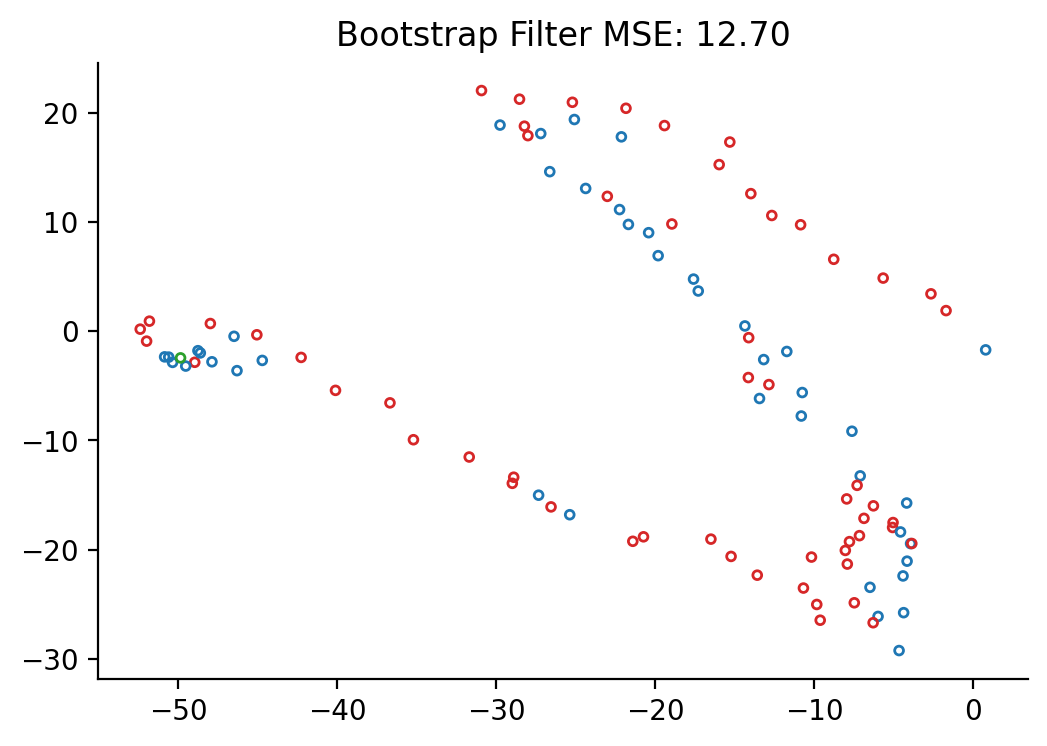

In [95]:
color_dict = {0: "tab:green", 1: "tab:red", 2: "tab:blue"}
latent_hist_est = latent_hist.mean(axis=1).round()
color_states_est = [color_dict[state] for state in latent_hist_est]


plt.scatter(*estimated_track.T, edgecolors=color_states_est, c="none", s=10)
plt.title(f"Bootstrap Filter MSE: {bf_mse:.2f}")
plt.show()

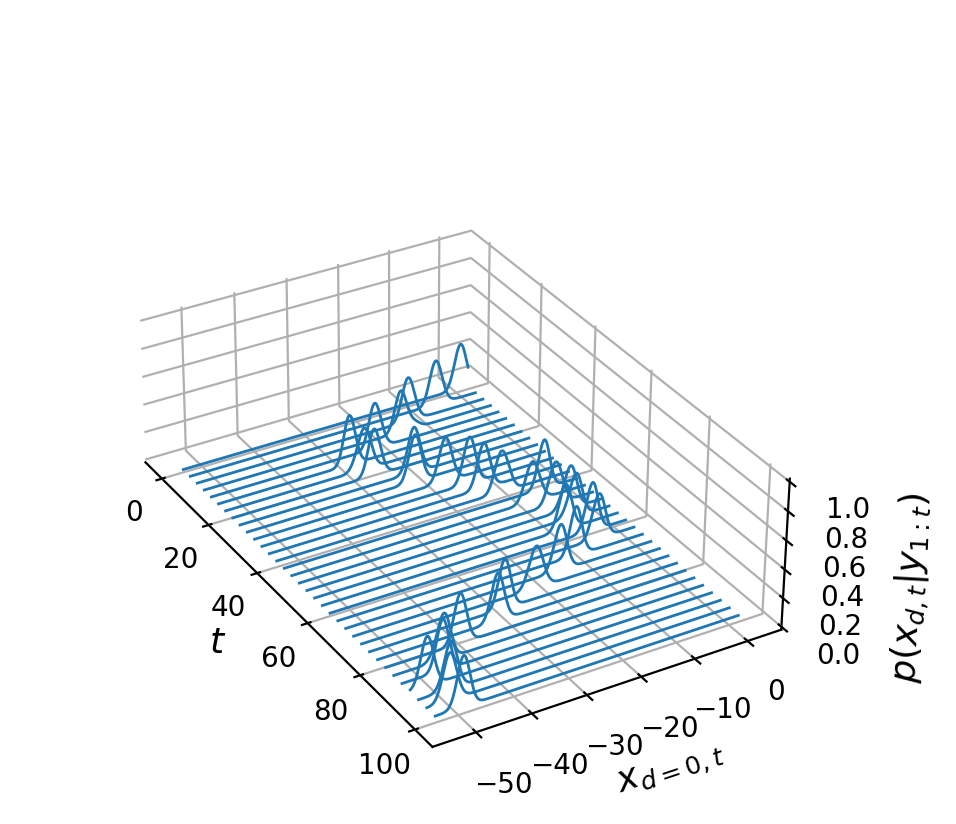

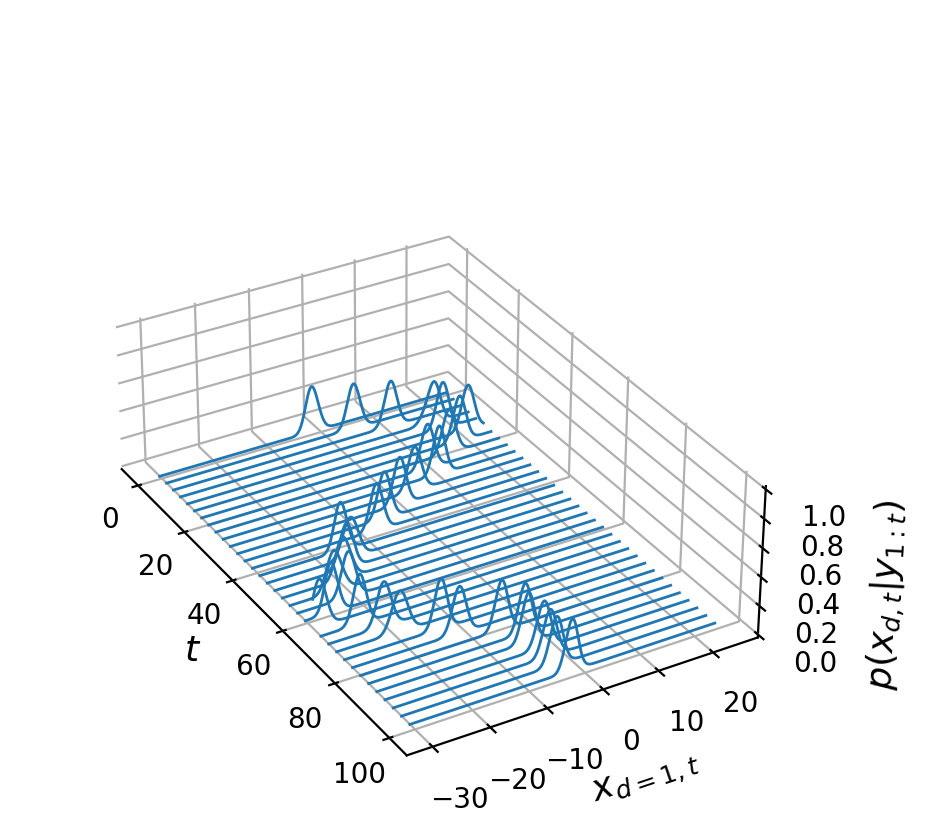

In [96]:
for i in range(2):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    plot_3d_belief_state(particles_track, i, ax, h=1.1)
    plt.tight_layout()
plt.show()